In [87]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# File directories
mdmr_dir = "/home/changbae/fmri_project/C-PAC/CPAC/bcb_mdmr/"
nas_dir = Path("/mnt/NAS2-2/data/")
MDMR_output_dir = nas_dir / "SAD_gangnam_MDMR"
fmri_prep_dir = nas_dir / "SAD_gangnam_resting_2" / "fMRIPrep_total"
seed_anal_dir = nas_dir / "SAD_gangnam_seed_based_analysis"
roi_filename = f"{MDMR_output_dir}/6mm/2/BFNE/result/cluster_masks/MDMR_significant_aal(Temporal_Mid_L)_label(1).nii.gz"
brain_mask_filename = f"{mdmr_dir}/template/all_final_group_mask_6mm.nii.gz"
conneciivity_file = f"{MDMR_output_dir}/6mm/2/BFNE/functional_connectivity_7_thick.csv"
valid_participant_file = f"{mdmr_dir}/input/valid_after_post_fmriprep_processing.csv"
regressor_file = f"{mdmr_dir}/regressor/gangnam_sad_BFNE_regressor_non_scaled.csv"

/tmp/ipykernel_1312979/3051663013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_connectivity_df['Group'] = filtered_connectivity_df['Participant'].apply(lambda x: 'HC' if x.startswith('c') else 'SAD')


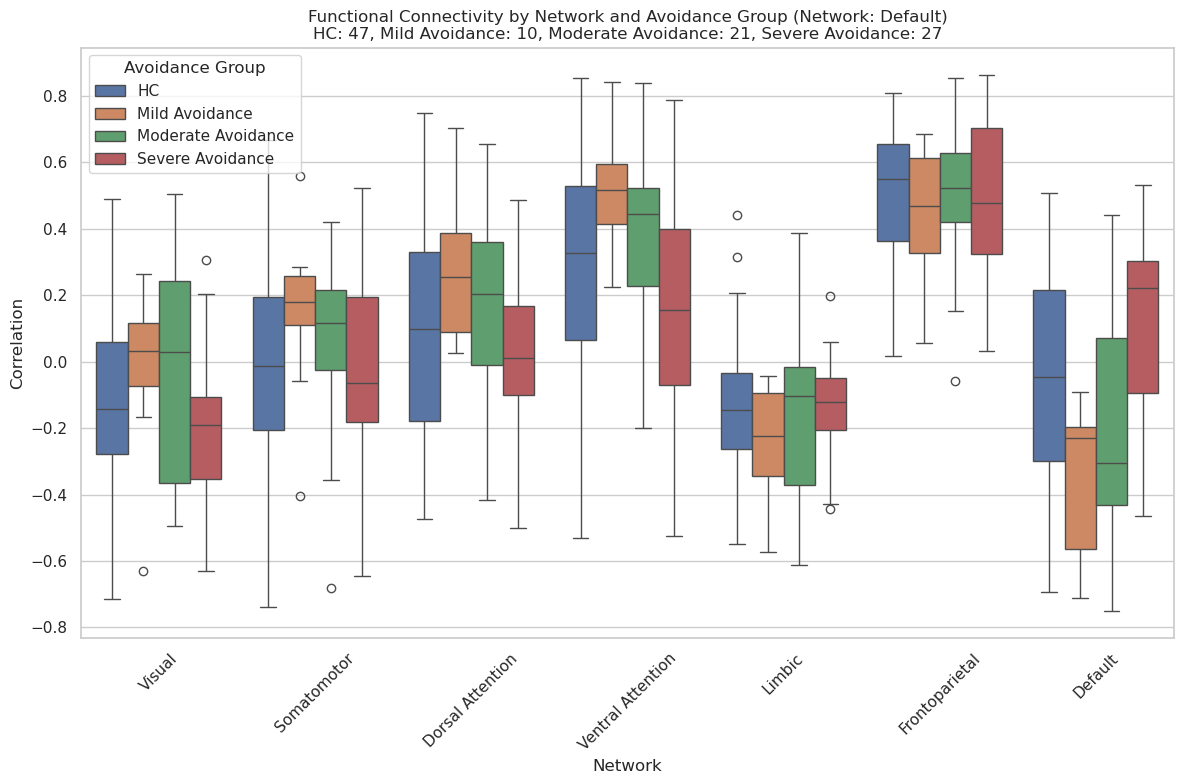

In [88]:
# Load the connectivity data and valid participant list
connectivity_df = pd.read_csv(conneciivity_file)
valid_participants_df = pd.read_csv(valid_participant_file)

# Extract valid participant IDs
valid_participants_df['Participant'] = valid_participants_df['Participant'].str.replace('sub-', '')
valid_participants = valid_participants_df['Participant'].unique()

# Filter connectivity data for valid participants
filtered_connectivity_df = connectivity_df[connectivity_df['Participant'].isin(valid_participants)]

# Add a 'Group' column based on Participant ID
filtered_connectivity_df['Group'] = filtered_connectivity_df['Participant'].apply(lambda x: 'HC' if x.startswith('c') else 'SAD')

# Load the regressor file
total_regressor_file = f"{mdmr_dir}/regressor/gangnam_total_LSAS_avoidance_regressor_non_scaled.csv"
total_regressor_df = pd.read_csv(total_regressor_file)

# Perform a left merge to ensure HC participants are included even if they don't have LSAS_avoidance scores
merged_df = pd.merge(total_regressor_df, filtered_connectivity_df, on='Participant', how='left')

# Classify participants into HC, mild, moderate, and severe based on LSAS_avoidance score
def classify_avoidance(row):
    if row['Group'] == 'HC':
        return 'HC'
    elif pd.isna(row['LSAS_avoidance']):
        return 'HC'  # In case of missing LSAS_avoidance for SAD, classify as HC for safety
    elif row['LSAS_avoidance'] < 24:
        return 'Mild Avoidance'
    elif 24 <= row['LSAS_avoidance'] <= 39:
        return 'Moderate Avoidance'
    else:
        return 'Severe Avoidance'

# Apply classification to avoid missing the HC group
merged_df['Avoidance Group'] = merged_df.apply(classify_avoidance, axis=1)

# Choose one network to count participants
network_of_interest = 'Default'  # Replace with the actual name of one network
default_df = merged_df[merged_df['Network'] == network_of_interest]

# Count the number of participants in each group for the selected network
group_counts = default_df['Avoidance Group'].value_counts()

# Create the updated box plot with specified group order for the selected network
plt.figure(figsize=(12, 8))
sns.boxplot(x='Network', y='Correlation', hue='Avoidance Group', data=merged_df, 
            hue_order=['HC', 'Mild Avoidance', 'Moderate Avoidance', 'Severe Avoidance'])

# Add participant counts to the title for the selected network
plt.title(f'Functional Connectivity by Network and Avoidance Group (Network: {network_of_interest})\n'
          f'HC: {group_counts.get("HC", 0)}, '
          f'Mild Avoidance: {group_counts.get("Mild Avoidance", 0)}, '
          f'Moderate Avoidance: {group_counts.get("Moderate Avoidance", 0)}, '
          f'Severe Avoidance: {group_counts.get("Severe Avoidance", 0)}')

plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_1312979/3114854281.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_connectivity_df['Group'] = filtered_connectivity_df['Participant'].apply(lambda x: 'HC' if x.startswith('c') else 'SAD')


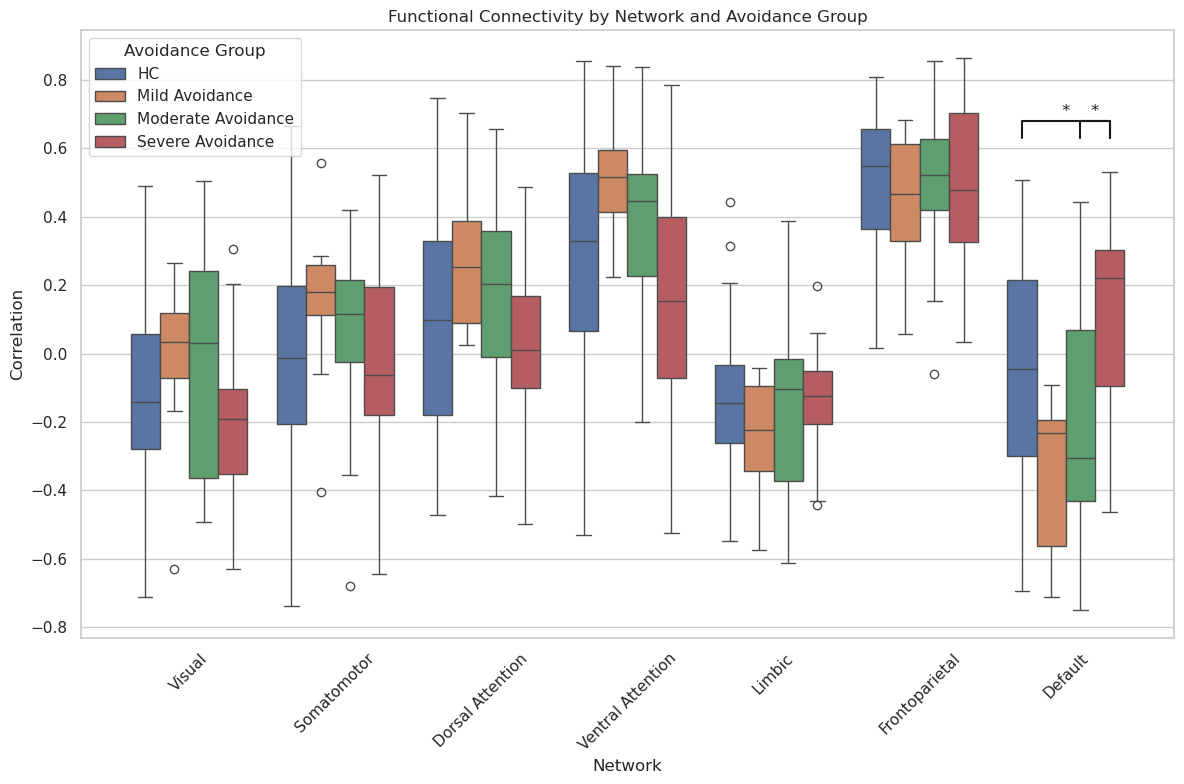

P-values for HC vs Other Groups:
Network: Visual, HC vs Mild Avoidance: p-value = 0.57455
Network: Visual, HC vs Moderate Avoidance: p-value = 0.67006
Network: Visual, HC vs Severe Avoidance: p-value = 0.05743
Network: Somatomotor, HC vs Mild Avoidance: p-value = 0.17828
Network: Somatomotor, HC vs Moderate Avoidance: p-value = 0.54968
Network: Somatomotor, HC vs Severe Avoidance: p-value = 0.71668
Network: Dorsal Attention, HC vs Mild Avoidance: p-value = 0.14370
Network: Dorsal Attention, HC vs Moderate Avoidance: p-value = 0.54984
Network: Dorsal Attention, HC vs Severe Avoidance: p-value = 0.11350
Network: Ventral Attention, HC vs Mild Avoidance: p-value = 0.05498
Network: Ventral Attention, HC vs Moderate Avoidance: p-value = 0.34145
Network: Ventral Attention, HC vs Severe Avoidance: p-value = 0.12076
Network: Limbic, HC vs Mild Avoidance: p-value = 0.15640
Network: Limbic, HC vs Moderate Avoidance: p-value = 0.62252
Network: Limbic, HC vs Severe Avoidance: p-value = 0.94841
Netw

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load the connectivity data and valid participant list
connectivity_df = pd.read_csv(conneciivity_file)
valid_participants_df = pd.read_csv(valid_participant_file)

# Extract valid participant IDs
valid_participants_df['Participant'] = valid_participants_df['Participant'].str.replace('sub-', '')
valid_participants = valid_participants_df['Participant'].unique()

# Filter connectivity data for valid participants
filtered_connectivity_df = connectivity_df[connectivity_df['Participant'].isin(valid_participants)]

# Add a 'Group' column based on Participant ID
filtered_connectivity_df['Group'] = filtered_connectivity_df['Participant'].apply(lambda x: 'HC' if x.startswith('c') else 'SAD')

# Load the regressor file
total_regressor_file = f"{mdmr_dir}/regressor/gangnam_total_LSAS_avoidance_regressor_non_scaled.csv"
total_regressor_df = pd.read_csv(total_regressor_file)

# Perform a left merge to ensure HC participants are included even if they don't have LSAS_avoidance scores
merged_df = pd.merge(total_regressor_df, filtered_connectivity_df, on='Participant', how='left')

# Classify participants into HC, mild, moderate, and severe based on LSAS_avoidance score
def classify_avoidance(row):
    if row['Group'] == 'HC':
        return 'HC'
    elif pd.isna(row['LSAS_avoidance']):
        return 'HC'  # In case of missing LSAS_avoidance for SAD, classify as HC for safety
    elif row['LSAS_avoidance'] < 24:
        return 'Mild Avoidance'
    elif 24 <= row['LSAS_avoidance'] <= 39:
        return 'Moderate Avoidance'
    else:
        return 'Severe Avoidance'

# Apply classification to avoid missing the HC group
merged_df['Avoidance Group'] = merged_df.apply(classify_avoidance, axis=1)

# List of networks
networks = merged_df['Network'].unique()

# Initialize a dictionary to store p-values
p_values = {}

# Create the boxplot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Network', y='Correlation', hue='Avoidance Group', data=merged_df, 
                 hue_order=['HC', 'Mild Avoidance', 'Moderate Avoidance', 'Severe Avoidance'])

# Perform statistical tests and annotate the plot
for i, network in enumerate(networks):
    # Filter data for the current network
    network_df = merged_df[merged_df['Network'] == network]
    
    # HC group data
    hc_group = network_df[network_df['Avoidance Group'] == 'HC']['Correlation']
    
    # Other groups
    groups_to_compare = ['Mild Avoidance', 'Moderate Avoidance', 'Severe Avoidance']
    positions = [-0.3, -0.1, 0.1]  # Adjust positions for annotations

    for pos, group in zip(positions, groups_to_compare):
        group_data = network_df[network_df['Avoidance Group'] == group]['Correlation']
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(hc_group, group_data, nan_policy='omit')
        
        # Store the p-value
        p_values[(network, 'HC', group)] = p_value

        # If p-value < 0.05, annotate the plot
        if p_value < 0.05:
            # Get the positions for annotation
            x1 = i + pos  # Position of the group to compare
            x2 = i + 0.3  # Position of HC group
            y, h, col = max(network_df['Correlation'].max() + 0.1, 0.5), 0.05, 'k'
            
            # Draw lines and add asterisk
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*0.5, y+h*1.1, '*', ha='center', va='bottom', color=col)
            
# Adjust plot settings
plt.title('Functional Connectivity by Network and Avoidance Group')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Print the p-values
print("P-values for HC vs Other Groups:")
for key, value in p_values.items():
    network, group1, group2 = key
    print(f"Network: {network}, {group1} vs {group2}: p-value = {value:.5f}")


In [90]:
from scipy import stats

# 선택한 네트워크별로 그룹 간의 기능적 연결 통계 테스트 (독립 표본 t-검정)
networks = merged_df['Network'].unique()

for network in networks:
    print(f"--- Statistical Test Results for Network: {network} ---")
    
    # 해당 네트워크에 대한 데이터만 필터링
    network_df = merged_df[merged_df['Network'] == network]
    
    # Severe Avoidance 그룹 데이터
    severe_group = network_df[network_df['Avoidance Group'] == 'HC']['Correlation']
    
    # HC 그룹 데이터와 비교
    hc_group = network_df[network_df['Avoidance Group'] == 'Mild Avoidance']['Correlation']
    t_stat_hc, p_value_hc = stats.ttest_ind(severe_group, hc_group, nan_policy='omit')
    print(f"HC vs Mild: t-statistic = {t_stat_hc:.3f}, p-value = {p_value_hc:.5f}")
    
    # Mild Avoidance 그룹 데이터와 비교
    mild_group = network_df[network_df['Avoidance Group'] == 'Moderate Avoidance']['Correlation']
    t_stat_mild, p_value_mild = stats.ttest_ind(severe_group, mild_group, nan_policy='omit')
    print(f"HC vs Moderate Avoidance: t-statistic = {t_stat_mild:.3f}, p-value = {p_value_mild:.5f}")
    
    # Moderate Avoidance 그룹 데이터와 비교
    moderate_group = network_df[network_df['Avoidance Group'] == 'Severe Avoidance']['Correlation']
    t_stat_moderate, p_value_moderate = stats.ttest_ind(severe_group, moderate_group, nan_policy='omit')
    print(f"HC vs Severe Avoidance: t-statistic = {t_stat_moderate:.3f}, p-value = {p_value_moderate:.5f}")
    
    print("\n")  # 각 네트워크별 결과를 구분하기 위한 줄바꿈

--- Statistical Test Results for Network: Visual ---
HC vs Mild: t-statistic = -0.565, p-value = 0.57455
HC vs Moderate Avoidance: t-statistic = -0.428, p-value = 0.67006
HC vs Severe Avoidance: t-statistic = 1.931, p-value = 0.05743


--- Statistical Test Results for Network: Somatomotor ---
HC vs Mild: t-statistic = -1.363, p-value = 0.17828
HC vs Moderate Avoidance: t-statistic = -0.601, p-value = 0.54968
HC vs Severe Avoidance: t-statistic = 0.364, p-value = 0.71668


--- Statistical Test Results for Network: Dorsal Attention ---
HC vs Mild: t-statistic = -1.483, p-value = 0.14370
HC vs Moderate Avoidance: t-statistic = -0.601, p-value = 0.54984
HC vs Severe Avoidance: t-statistic = 1.602, p-value = 0.11350


--- Statistical Test Results for Network: Ventral Attention ---
HC vs Mild: t-statistic = -1.961, p-value = 0.05498
HC vs Moderate Avoidance: t-statistic = -0.958, p-value = 0.34145
HC vs Severe Avoidance: t-statistic = 1.570, p-value = 0.12076


--- Statistical Test Results f

In [91]:
len(regressor_df["Participant"].unique())

58

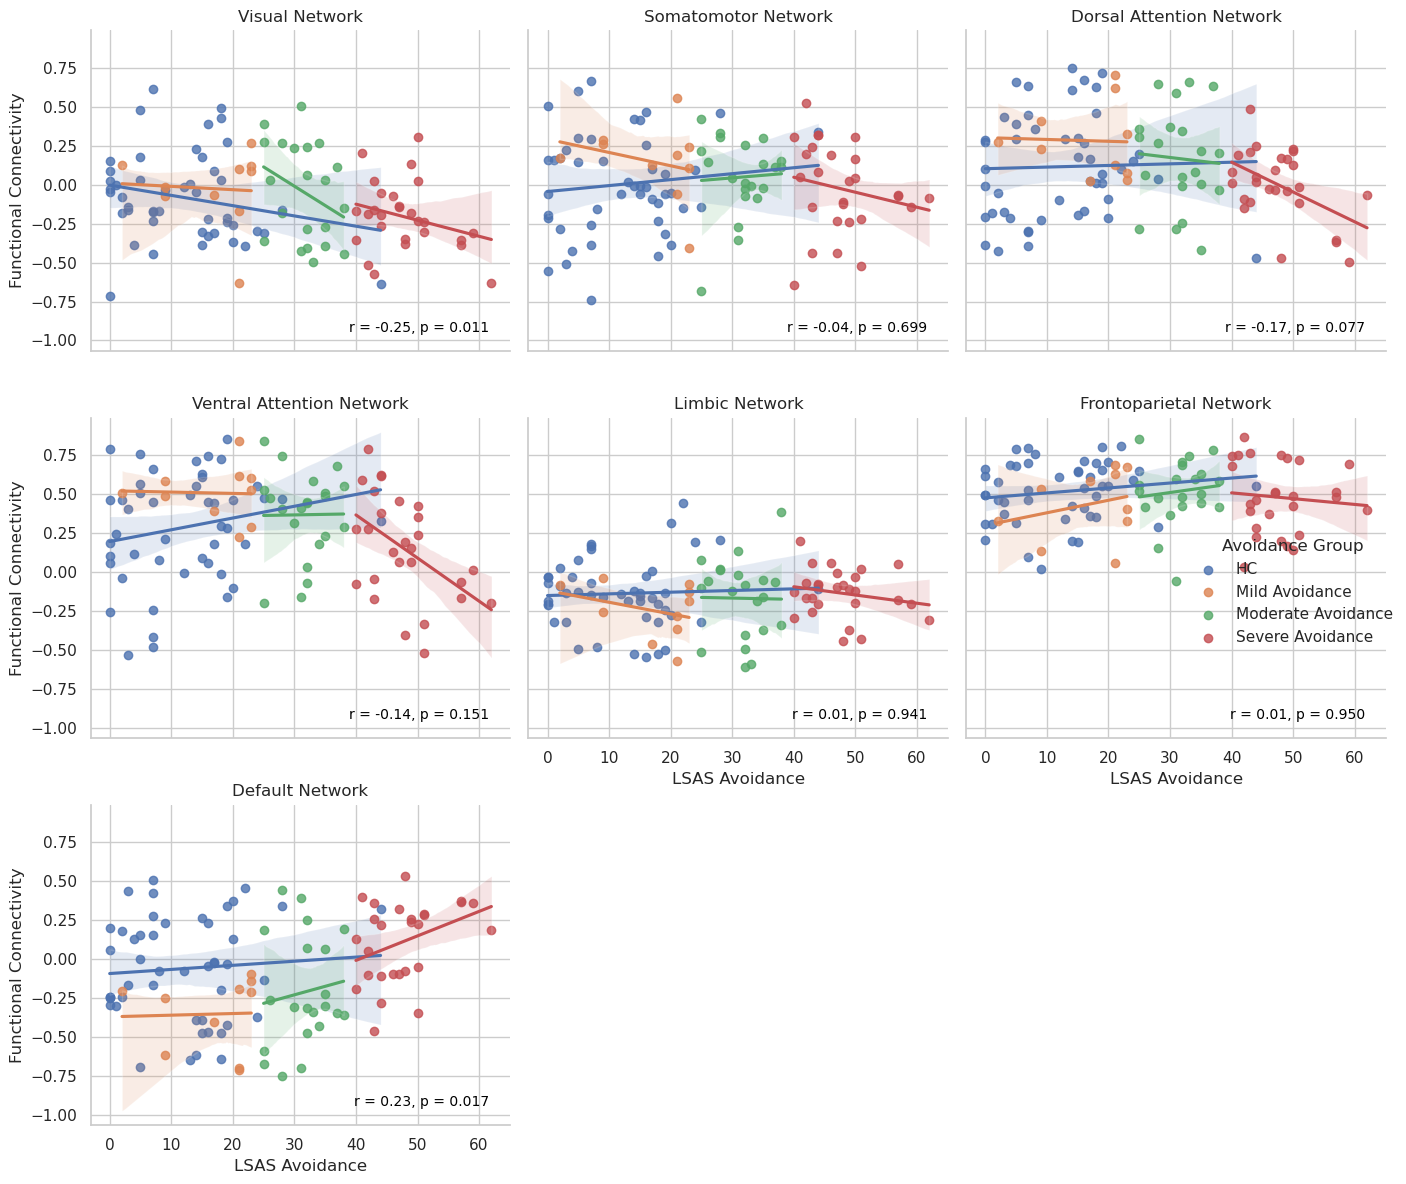

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the files
connectivity_df = pd.read_csv(conneciivity_file)
valid_participants_df = pd.read_csv(valid_participant_file)
regressor_df = pd.read_csv(total_regressor_file)

# Clean participant IDs in valid participant file
valid_participants_df['Participant'] = valid_participants_df['Participant'].str.replace('sub-', '')
valid_participants = valid_participants_df['Participant'].unique()

# Filter connectivity data for valid participants
filtered_connectivity_df = connectivity_df[connectivity_df['Participant'].isin(valid_participants)]

# Merge connectivity data with the regressor file based on Participant
merged_df = pd.merge(filtered_connectivity_df, regressor_df, on='Participant')

# Add a 'Group' column based on Participant ID (assuming 'c' for HC, 's' for SAD)
merged_df['Group'] = merged_df['Participant'].apply(lambda x: 'HC' if x.startswith('c') else 'SAD')

# Classify participants into HC, mild, moderate, and severe based on LSAS_avoidance score
def classify_avoidance(row):
    if row['Group'] == 'HC':
        return 'HC'
    elif pd.isna(row['LSAS_avoidance']):
        return 'HC'  # In case of missing LSAS_avoidance for SAD, classify as HC for safety
    elif row['LSAS_avoidance'] < 24:
        return 'Mild Avoidance'
    elif 24 <= row['LSAS_avoidance'] <= 39:
        return 'Moderate Avoidance'
    else:
        return 'Severe Avoidance'

# Apply classification
merged_df['Avoidance Group'] = merged_df.apply(classify_avoidance, axis=1)

# Initialize an empty dictionary to store correlation values for each network
correlation_stats = {}

# Calculate correlation (Pearson's r) for each network
networks = merged_df['Network'].unique()

for network in networks:
    # Filter data for the current network
    network_data = merged_df[merged_df['Network'] == network]
    
    # Calculate the Pearson correlation
    r_value, p_value = pearsonr(network_data['LSAS_avoidance'], network_data['Correlation'])
    
    # Store the correlation values (r and p)
    correlation_stats[network] = (r_value, p_value)

# Now we will plot the lmplot and add the correlation statistics as annotations
sns.set(style="whitegrid")

# Specify the order of the Avoidance Group labels
hue_order = ['HC', 'Mild Avoidance', 'Moderate Avoidance', 'Severe Avoidance']

g = sns.lmplot(x='LSAS_avoidance', y='Correlation', col='Network', data=merged_df, col_wrap=3, height=4, aspect=1, hue="Avoidance Group", hue_order=hue_order)

# Add correlation coefficients to each plot and move the text annotation to the bottom-right corner
for ax, network in zip(g.axes.flat, networks):
    r, p = correlation_stats[network]
    ax.text(0.95, 0.05, f'r = {r:.2f}, p = {p:.3f}', transform=ax.transAxes, 
            verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

g.set_titles("{col_name} Network")
g.set_axis_labels("LSAS Avoidance", "Functional Connectivity")
plt.tight_layout()

# Show the plot with correlation annotations
plt.show()


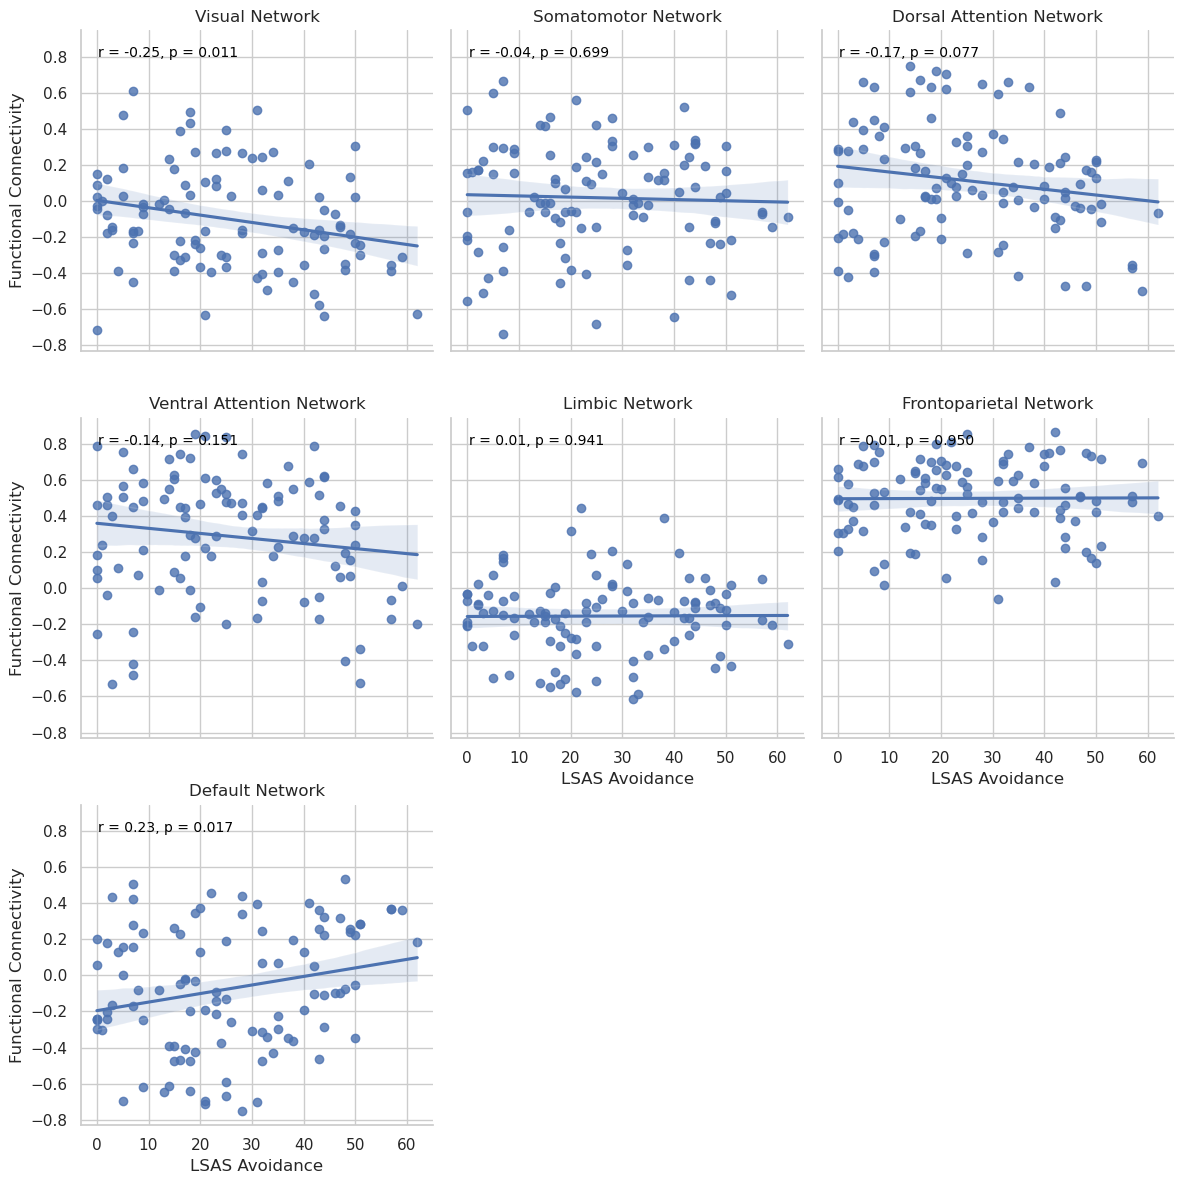

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the files
connectivity_df = pd.read_csv(conneciivity_file)
valid_participants_df = pd.read_csv(valid_participant_file)
regressor_df = pd.read_csv(total_regressor_file)

# Clean participant IDs in valid participant file
valid_participants_df['Participant'] = valid_participants_df['Participant'].str.replace('sub-', '')
valid_participants = valid_participants_df['Participant'].unique()

# Filter connectivity data for valid participants
filtered_connectivity_df = connectivity_df[connectivity_df['Participant'].isin(valid_participants)]

# Merge connectivity data with the regressor file based on Participant
merged_df = pd.merge(filtered_connectivity_df, regressor_df, on='Participant')

# Add a 'Group' column based on Participant ID (assuming 'c' for HC, 's' for SAD)
merged_df['Group'] = merged_df['Participant'].apply(lambda x: 'HC' if x.startswith('c') else 'SAD')

# Classify participants into HC, mild, moderate, and severe based on LSAS_avoidance score
def classify_avoidance(row):
    if row['Group'] == 'HC':
        return 'HC'
    elif pd.isna(row['LSAS_avoidance']):
        return 'HC'  # In case of missing LSAS_avoidance for SAD, classify as HC for safety
    elif row['LSAS_avoidance'] < 24:
        return 'Mild Avoidance'
    elif 24 <= row['LSAS_avoidance'] <= 39:
        return 'Moderate Avoidance'
    else:
        return 'Severe Avoidance'

# Apply classification
merged_df['Avoidance Group'] = merged_df.apply(classify_avoidance, axis=1)

# Initialize an empty dictionary to store correlation values for each network
correlation_stats = {}

# Calculate correlation (Pearson's r) for each network
networks = merged_df['Network'].unique()

for network in networks:
    # Filter data for the current network
    network_data = merged_df[merged_df['Network'] == network]
    
    # Calculate the Pearson correlation
    r_value, p_value = pearsonr(network_data['LSAS_avoidance'], network_data['Correlation'])
    
    # Store the correlation values (r and p)
    correlation_stats[network] = (r_value, p_value)

# Now we will plot the lmplot and add the correlation statistics as annotations
sns.set(style="whitegrid")

g = sns.lmplot(x='LSAS_avoidance', y='Correlation', col='Network', data=merged_df, col_wrap=3, height=4, aspect=1)

# Add correlation coefficients to each plot
for ax, network in zip(g.axes.flat, networks):
    r, p = correlation_stats[network]
    ax.text(0.05, 0.95, f'r = {r:.2f}, p = {p:.3f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, color='black')

g.set_titles("{col_name} Network")
g.set_axis_labels("LSAS Avoidance", "Functional Connectivity")
plt.tight_layout()

# Show the plot with correlation annotations
plt.show()

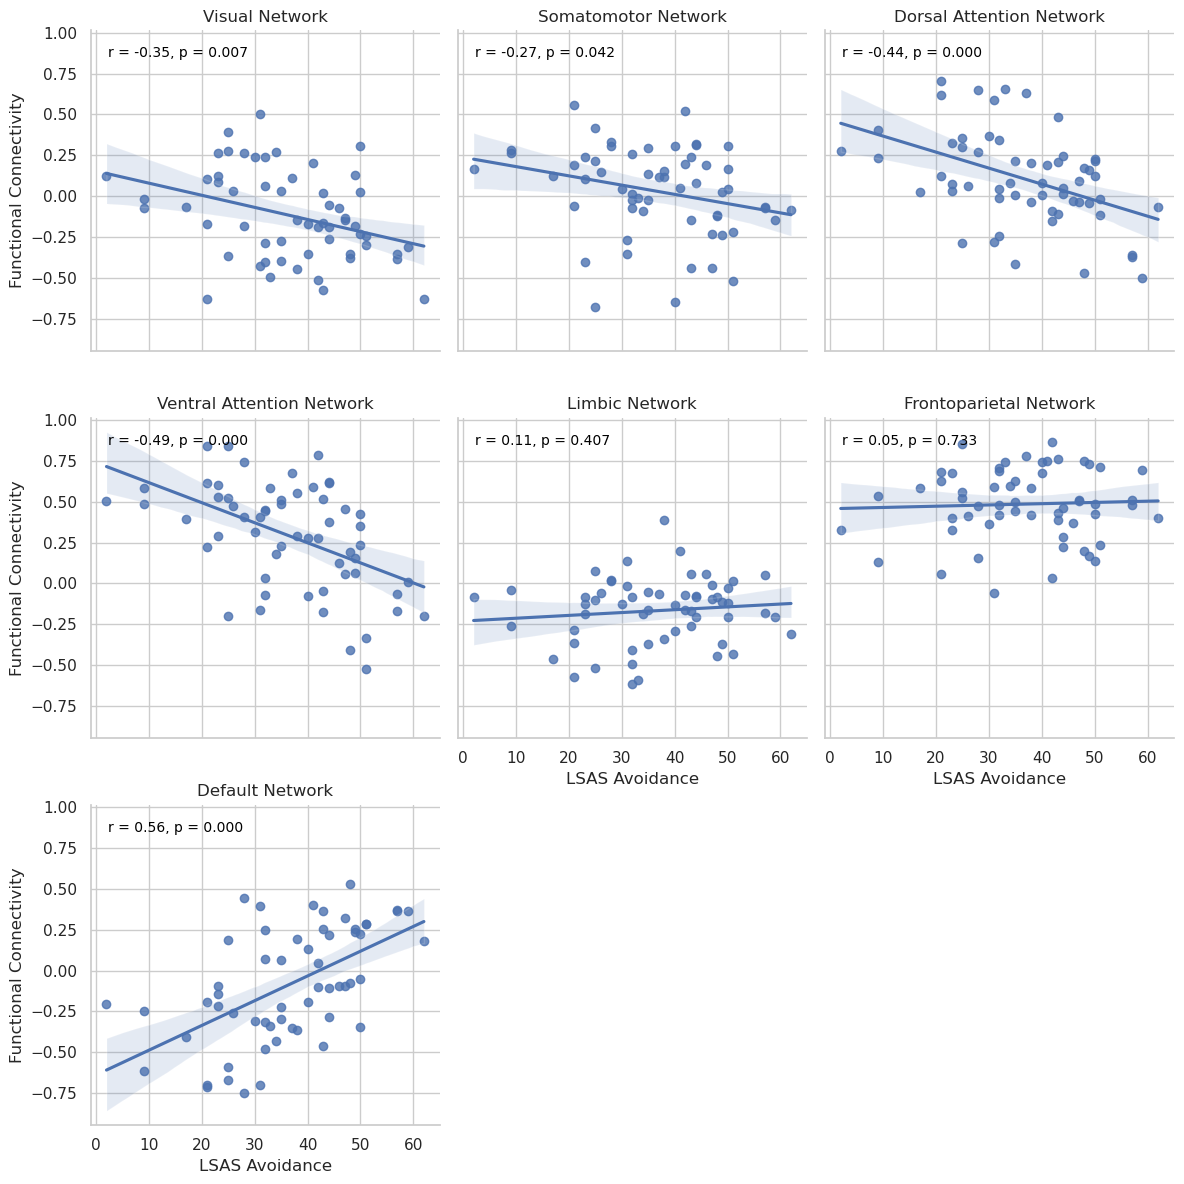

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the files
connectivity_df = pd.read_csv(conneciivity_file)
valid_participants_df = pd.read_csv(valid_participant_file)
regressor_df = pd.read_csv(regressor_file)

# Clean participant IDs in valid participant file
valid_participants_df['Participant'] = valid_participants_df['Participant'].str.replace('sub-', '')
valid_participants = valid_participants_df['Participant'].unique()

# Filter connectivity data for valid participants
filtered_connectivity_df = connectivity_df[connectivity_df['Participant'].isin(valid_participants)]

# Merge connectivity data with the regressor file based on Participant
merged_df = pd.merge(filtered_connectivity_df, regressor_df, on='Participant')

# Add a 'Group' column based on Participant ID (assuming 'c' for HC, 's' for SAD)
merged_df['Group'] = merged_df['Participant'].apply(lambda x: 'HC' if x.startswith('c') else 'SAD')

# Classify participants into HC, mild, moderate, and severe based on LSAS_avoidance score
def classify_avoidance(row):
    if row['Group'] == 'HC':
        return 'HC'
    elif pd.isna(row['LSAS_avoidance']):
        return 'HC'  # In case of missing LSAS_avoidance for SAD, classify as HC for safety
    elif row['LSAS_avoidance'] < 24:
        return 'Mild Avoidance'
    elif 24 <= row['LSAS_avoidance'] <= 39:
        return 'Moderate Avoidance'
    else:
        return 'Severe Avoidance'

# Apply classification
merged_df['Avoidance Group'] = merged_df.apply(classify_avoidance, axis=1)

# Initialize an empty dictionary to store correlation values for each network
correlation_stats = {}

# Calculate correlation (Pearson's r) for each network
networks = merged_df['Network'].unique()

for network in networks:
    # Filter data for the current network
    network_data = merged_df[merged_df['Network'] == network]
    
    # Calculate the Pearson correlation
    r_value, p_value = pearsonr(network_data['LSAS_avoidance'], network_data['Correlation'])
    
    # Store the correlation values (r and p)
    correlation_stats[network] = (r_value, p_value)

# Now we will plot the lmplot and add the correlation statistics as annotations
sns.set(style="whitegrid")

g = sns.lmplot(x='LSAS_avoidance', y='Correlation', col='Network', data=merged_df, col_wrap=3, height=4, aspect=1)

# Add correlation coefficients to each plot
for ax, network in zip(g.axes.flat, networks):
    r, p = correlation_stats[network]
    ax.text(0.05, 0.95, f'r = {r:.2f}, p = {p:.3f}', transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, color='black')

g.set_titles("{col_name} Network")
g.set_axis_labels("LSAS Avoidance", "Functional Connectivity")
plt.tight_layout()

# Show the plot with correlation annotations
plt.show()